# Setup

In [33]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [34]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 03/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig3'

In [35]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

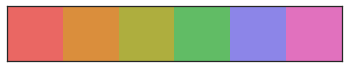

In [36]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [37]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [38]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

### Load formatted scores

In [39]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

### Calculate lights off and on in Zeitgeber time (s and hrs)

In [40]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [41]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

# Values for transition matrices

In [42]:
nNodes = len(stages)

stage_names = ['wake', 'drowsy', 'uni', 'IS', 'SWS', 'REM']

## get NIGHTTIME scores only 

In [43]:
nightScores = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]
    
    start = str(lightsOffDatetime[b]).replace('T', ' ')
    end = str(lightsOnDatetime[b]).replace('T', ' ')

    nightScores[b_name] = Scores[start:end]

# Get_transition_matrix

In [44]:
def Get_transition_matrix(transitions, proportions=True):
    '''
    from code here: https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
    
    Inputs
        transitions: a list of states labeled as successive integers starting with 0
        proportions: whether to return transitions as proportion (ie probability), or total number of transitions'
        
    Returns:
        a transition matrix, M, where M[i][j] is the probability of transitioning from i to j
    '''
    
    n = 1 + max(transitions) # number of states

    M = [[0]*n for _ in range(n)] # init transition matrix

    for (i,j) in zip(transitions,transitions[1:]): # count each transition
        M[i][j] += 1

    # now convert to probabilities:
    if proportions:
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row] # divide by number of total transitions from each state
                
    return M

# chordDiagram

In [45]:
# Code by https://github.com/fengwangPhysics/matplotlib-chord-diagram/blob/master/matplotlib-chord.py

###################
# chord diagram
from matplotlib.path import Path
import matplotlib.patches as patches

import numpy as np

LW = 0.3

def polar2xy(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def hex2rgb(c):
    return tuple(int(c[i:i+2], 16)/256.0 for i in (1, 3 ,5))

def IdeogramArc(start=0, end=60, radius=1.0, width=0.2, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    # optimal distance to the control points
    # https://stackoverflow.com/questions/1734745/how-to-create-circle-with-b%C3%A9zier-curves
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    inner = radius*(1-width)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(inner, end),
        polar2xy(inner, end) + polar2xy(opt*(1-width), end-0.5*np.pi),
        polar2xy(inner, start) + polar2xy(opt*(1-width), start+0.5*np.pi),
        polar2xy(inner, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.LINETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CLOSEPOLY,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)


def ChordArc(start1=0, end1=60, start2=180, end2=240, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start1 > end1:
        start1, end1 = end1, start1
    if start2 > end2:
        start2, end2 = end2, start2
    start1 *= np.pi/180.
    end1 *= np.pi/180.
    start2 *= np.pi/180.
    end2 *= np.pi/180.
    opt1 = 4./3. * np.tan((end1-start1)/ 4.) * radius
    opt2 = 4./3. * np.tan((end2-start2)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start1),
        polar2xy(radius, start1) + polar2xy(opt1, start1+0.5*np.pi),
        polar2xy(radius, end1) + polar2xy(opt1, end1-0.5*np.pi),
        polar2xy(radius, end1),
        polar2xy(rchord, end1),
        polar2xy(rchord, start2),
        polar2xy(radius, start2),
        polar2xy(radius, start2) + polar2xy(opt2, start2+0.5*np.pi),
        polar2xy(radius, end2) + polar2xy(opt2, end2-0.5*np.pi),
        polar2xy(radius, end2),
        polar2xy(rchord, end2),
        polar2xy(rchord, start1),
        polar2xy(radius, start1),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def selfChordArc(start=0, end=60, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(rchord, end),
        polar2xy(rchord, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def chordDiagram(X, ax, colors=None, width=0.1, pad=2, chordwidth=0.7):
    """Plot a chord diagram
    Parameters
    ----------
    X :
        flux data, X[i, j] is the flux from i to j
    ax :
        matplotlib `axes` to show the plot
    colors : optional
        user defined colors in rgb format. Use function hex2rgb() to convert hex color to rgb color. Default: d3.js category10
    width : optional
        width/thickness of the ideogram arc
    pad : optional
        gap pad between two neighboring ideogram arcs, unit: degree, default: 2 degree
    chordwidth : optional
        position of the control points for the chords, controlling the shape of the chords
    """
    # X[i, j]:  i -> j
    x = X.sum(axis = 1) # sum over rows
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    if colors is None:
    # use d3.js category10 https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        if len(x) > 10:
            print('x is too large! Use x smaller than 10')
        colors = [hex2rgb(colors[i]) for i in range(len(x))]

    # find position for each start and end
    y = x/np.sum(x).astype(float) * (360 - pad*len(x))

    pos = {}
    arc = []
    nodePos = []
    start = 0
    for i in range(len(x)):
        end = start + y[i]
        arc.append((start, end))
        angle = 0.5*(start+end)
        #print(start, end, angle)
        if -30 <= angle <= 210:
            angle -= 90
        else:
            angle -= 270
        nodePos.append(tuple(polar2xy(1.1, 0.5*(start+end)*np.pi/180.)) + (angle,))
        z = (X[i, :]/x[i].astype(float)) * (end - start)
        ids = np.argsort(z)
        z0 = start
        for j in ids:
            pos[(i, j)] = (z0, z0+z[j])
            z0 += z[j]
        start = end + pad

    for i in range(len(x)):
        start, end = arc[i]
        IdeogramArc(start=start, end=end, radius=1.0, ax=ax, color=colors[i], width=width)
        start, end = pos[(i,i)]
        selfChordArc(start, end, radius=1.-width, color=colors[i], chordwidth=chordwidth*0.7, ax=ax)
        for j in range(i):
            color = colors[i]
            if X[i, j] > X[j, i]:
                color = colors[j]
            start1, end1 = pos[(i,j)]
            start2, end2 = pos[(j,i)]
            ChordArc(start1, end1, start2, end2,
                     radius=1.-width, color=colors[i], chordwidth=chordwidth, ax=ax)

    #print(nodePos)
    return nodePos

##################################

# Test using small subset of data

In [46]:
testdata = AllScores['Bird 1'][0:20] # pick data subset
testdata

,Video Label,Label,Label (#),Time (s),Time (h),Zeitgeber time (s),Zeitgeber time (h),Zeitgeber time (ep),Epoch #
2014-10-17 17:32:06,q,w,0,0,0.000000,-46449,-12.902500,-15483,0
2014-10-17 17:32:09,q,w,0,3,0.000833,-46446,-12.901667,-15482,1
2014-10-17 17:32:12,q,w,0,6,0.001667,-46443,-12.900833,-15481,2
2014-10-17 17:32:15,q,w,0,9,0.002500,-46440,-12.900000,-15480,3
2014-10-17 17:32:18,q,w,0,12,0.003333,-46437,-12.899167,-15479,4
2014-10-17 17:32:21,q,w,0,15,0.004167,-46434,-12.898333,-15478,5
2014-10-17 17:32:24,q,w,0,18,0.005000,-46431,-12.897500,-15477,6
2014-10-17 17:32:27,d,s,4,21,0.005833,-46428,-12.896667,-15476,7
2014-10-17 17:32:30,d,d,1,24,0.006667,-46425,-12.895833,-15475,8
2014-10-17 17:32:33,s,i,3,27,0.007500,-46422,-12.895000,-15474,9


In [47]:
transitions = testdata['Label (#)']

In [48]:
np.unique(transitions) # the unique states contained in this dataset

array([0, 1, 3, 4, 5])

In [49]:
# generate transition matrix
m = Get_transition_matrix(transitions)
print('W     D     U    I    S    R')
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

W     D     U    I    S    R
0.86 0.00 0.00 0.00 0.14 0.00
0.00 0.80 0.00 0.20 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.33 0.33 0.33
0.00 0.67 0.00 0.00 0.33 0.00
0.00 0.00 0.00 1.00 0.00 0.00


In [50]:
transitions.values

array([0, 0, 0, 0, 0, 0, 0, 4, 1, 3, 3, 5, 3, 4, 4, 1, 1, 1, 1, 1])

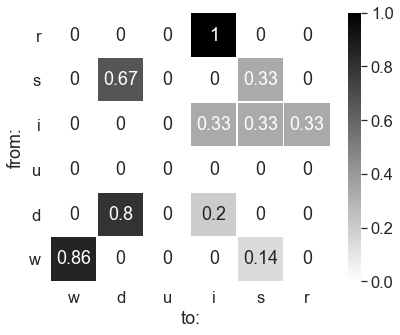

In [51]:
plt.figure(figsize=(6,5))

sns.heatmap(m, cmap='gray_r', annot=True, linewidths=.5)
plt.ylabel('from:')
plt.yticks(np.arange(6)+0.5, stages, rotation=0);
plt.xlabel('to:')
plt.xticks(np.arange(6)+0.5, stages, rotation=0);

plt.ylim(0,6)
plt.xlim(0,6)
plt.tight_layout()

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide


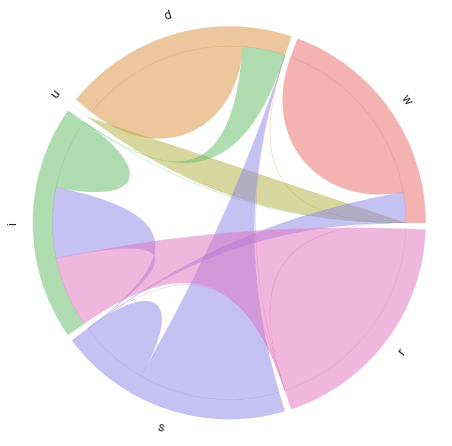

In [52]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes([0,0,1,1])


nodePos = chordDiagram(np.array(m), ax, colors=colors)

ax.axis('off')

prop = dict(fontsize=16*0.8, ha='center', va='center')
for i in range(nNodes):
    ax.text(nodePos[i][0], nodePos[i][1], stages[i], rotation=nodePos[i][2], **prop)

# Run on all data

## Individual transition matrices

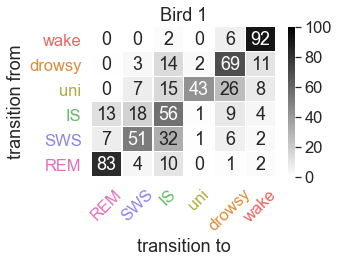

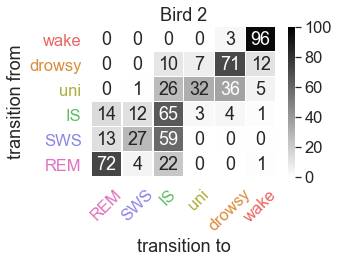

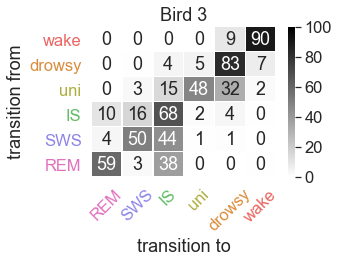

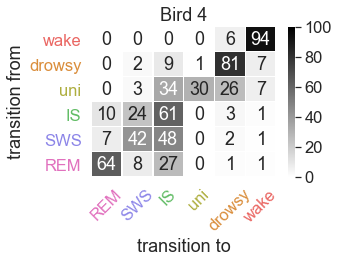

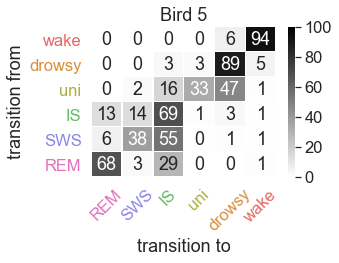

In [53]:
for b in range(nBirds):
    
    bird_name = 'Bird ' + str(b+1)
    transitions = AllScores[bird_name]['Label (#)']

    # generate transition matrix
    transition_matrix = Get_transition_matrix(transitions)

    # plot
    plt.figure(figsize=(5,4))
    sns.heatmap(100*np.array(transition_matrix), cmap='gray_r', vmin=0, vmax=100, linewidths=.5, annot=True, fmt=".0f")
    
    # formatting
    plt.ylabel('transition from')
    plt.yticks(np.arange(6)+0.5, stage_names, rotation=0);
    plt.xlabel('transition to')
    plt.xticks(np.arange(6)+0.5, stage_names, rotation=45);
    plt.title(bird_name)
    
    ax = plt.gca()
    for xtick, color in zip(ax.get_xticklabels(), colors):   # text color
        xtick.set_color(color)

    for ytick, color in zip(ax.get_yticklabels(), colors):   # text color
        ytick.set_color(color)
        
    plt.tight_layout()
    plt.ylim(6,0)
    plt.xlim(6,0)
    
    if savePlots:
        plt.savefig(saveAsPath + saveAsName + 'h_Revision_transition_matix_' + bird_name + '.pdf')


### save to csvs

In [61]:
if saveData:
    for b in range(nBirds):
    
        bird_name = 'Bird ' + str(b+1)
        transitions = AllScores[bird_name]['Label (#)']

        # generate transition matrix
        transition_matrix = pd.DataFrame(Get_transition_matrix(transitions),
                                         index=['from ' + x for x in stage_names],
                                         columns=['to ' + x for x in stage_names])

        transition_matrix.to_csv(saveAsPath + saveAsName + 'e_transition_matrix_' + bird_name + '.csv')

## Get mean transition matrices

In [55]:
mean_transition_matrix = np.zeros((nNodes, nNodes))

for b in range(nBirds):
    
    bird_name = 'Bird ' + str(b+1)
    transitions = AllScores[bird_name]['Label (#)']

    # generate transition matrix
    transition_matrix = Get_transition_matrix(transitions)
    
    mean_transition_matrix += np.array(transition_matrix)

# Take average across birds
mean_transition_matrix = mean_transition_matrix/nBirds

In [56]:
mean_transition_matrix

array([[9.30713731e-01, 6.26854033e-02, 1.19558935e-03, 4.68470452e-03,
        3.54369354e-04, 3.66202701e-04],
       [8.26218399e-02, 7.88562143e-01, 3.47953953e-02, 8.04483870e-02,
        1.23750939e-02, 1.19714135e-03],
       [4.59457483e-02, 3.36412360e-01, 3.71603542e-01, 2.14411641e-01,
        3.07401931e-02, 8.86515160e-04],
       [1.44743076e-02, 4.50613456e-02, 1.38423634e-02, 6.37330950e-01,
        1.67573434e-01, 1.21717599e-01],
       [8.84809184e-03, 2.18640930e-02, 3.58040089e-03, 4.75452799e-01,
        4.17662632e-01, 7.25919830e-02],
       [1.00123135e-02, 5.37735127e-03, 1.54753263e-04, 2.51459581e-01,
        4.23112532e-02, 6.90684748e-01]])

### save to csv

In [57]:
if saveData:
    tmp = pd.DataFrame(mean_transition_matrix,
                         index=['from ' + x for x in stage_names],
                         columns=['to ' + x for x in stage_names])
    
    tmp.to_csv(saveAsPath + saveAsName + 'f-h_mean_transition_matrix.csv')

## FIGURE 3H: mean transition matrix

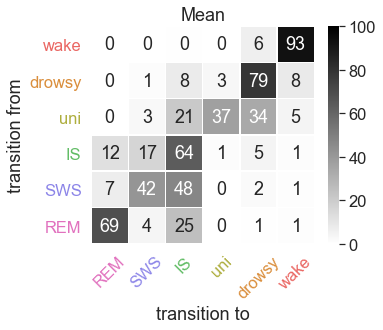

In [58]:
# plot
plt.figure(figsize=(5,4))
sns.heatmap(100*np.array(mean_transition_matrix), cmap='gray_r', vmin=0, vmax=100, linewidths=.5, annot=True, fmt=".0f")

# formatting
plt.ylabel('transition from')
plt.yticks(np.arange(6)+0.5, stage_names, rotation=0);
plt.xlabel('transition to')
plt.xticks(np.arange(6)+0.5, stage_names, rotation=45);
plt.title('Mean')

ax = plt.gca()
for xtick, color in zip(ax.get_xticklabels(), colors):   # text color
    xtick.set_color(color)

for ytick, color in zip(ax.get_yticklabels(), colors):   # text color
    ytick.set_color(color)
    
plt.ylim(6,0)
plt.xlim(6,0)

if savePlots:
    plt.savefig(saveAsPath + saveAsName + 'h_Revision_transition_matix_MEAN.pdf')

# Plot chord diagrams

## FIGURE 3E: individual chord diagrams

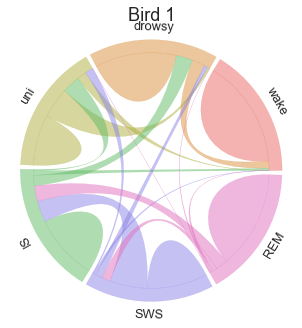

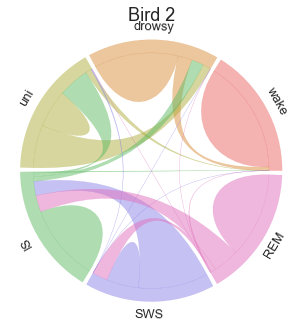

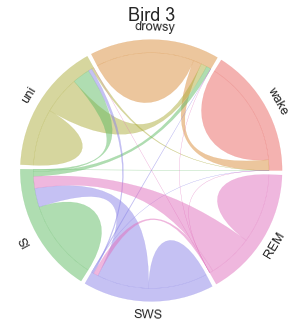

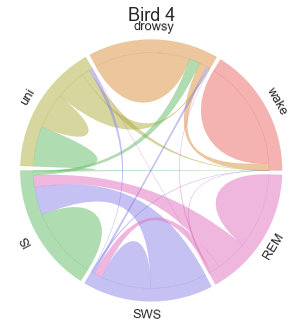

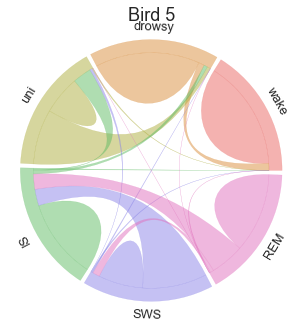

In [59]:
for b in range(nBirds):
    
    bird_name = 'Bird ' + str(b+1)
    transitions = AllScores[bird_name]['Label (#)']

    # generate transition matrix
    transition_matrix = Get_transition_matrix(transitions, proportions=True)
    
    # Round to 2 decimals
    transition_matrix = np.round(transition_matrix, decimals=2)

    fig = plt.figure(figsize=(4,4))
    ax = plt.axes([0,0,1,1])

    nodePos = chordDiagram(np.array(transition_matrix), ax, colors=colors)

    ax.axis('off')

    prop = dict(fontsize=16*0.8, ha='center', va='center')
    for i in range(nNodes):
        ax.text(nodePos[i][0], nodePos[i][1], stage_names[i], rotation=nodePos[i][2], **prop)
        
    plt.title(bird_name)
    
    if savePlots:
        plt.savefig(saveAsPath + saveAsName + 'e_Revision_transitions_chord_diagram_' + bird_name + '.pdf')


## FIGURE 3F-G: Mean chord diagram

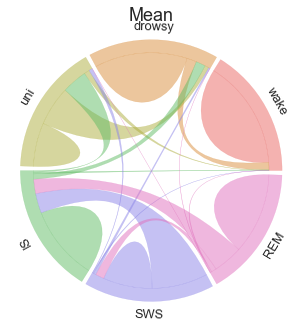

In [60]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes([0,0,1,1])

nodePos = chordDiagram(np.array(mean_transition_matrix), ax, colors=colors)

ax.axis('off')

prop = dict(fontsize=16*0.8, ha='center', va='center')
for i in range(nNodes):
    ax.text(nodePos[i][0], nodePos[i][1], stage_names[i], rotation=nodePos[i][2], **prop)

plt.title('Mean')

if savePlots:
    plt.savefig(saveAsPath + saveAsName + 'f-g_Revision_transitions_chord_diagram_MEAN.pdf')